# Multi-Turn Chat Benchmark

```bash
gcloud container clusters create-auto cluster-1 \
    --location=us-central1

helm repo add kubeai https://www.kubeai.org
helm repo update
curl -L -O https://raw.githubusercontent.com/substratusai/kubeai/refs/heads/main/charts/kubeai/values-gke.yaml
helm upgrade --install kubeai kubeai/kubeai \
    -f values-gke.yaml \
    --set secrets.huggingface.token=$HUGGING_FACE_HUB_TOKEN \
    --set metrics.prometheusOperator.vLLMPodMonitor.enabled=true \
    --set open-webui.enabled=false \
    --wait
```

In [1]:
from subprocess import run, PIPE
import json
from kubernetes import client, config, dynamic
from kubernetes.client import api_client
from copy import deepcopy

In [2]:
k8s_config = config.load_kube_config()

k8s_client = dynamic.DynamicClient(
    api_client.ApiClient(configuration=k8s_config)
)
models_client = k8s_client.resources.get(api_version="kubeai.org/v1", kind="Model")

v1 = client.CoreV1Api()

namespace = "default"

In [3]:
benchmark_pod_spec = {
    "apiVersion": "v1",
    "kind": "Pod",
    "metadata": {
        "name": "bench"
    },
    "spec": {
        "restartPolicy": "Never",
        "containers": [
            {
                "name": "bench",
                "image": "us-central1-docker.pkg.dev/substratus-dev/default/benchmark-multi-turn-chat-go:v0.1.1",
                "imagePullPolicy": "Always",
                "command": ["sleep", "infinity"],
                "env": [
                    {
                        "name": "OPENAI_BASE_URL",
                        "value": "http://kubeai/openai/v1"
                    }
                ],
                "resources": {
                    "requests": {
                        "cpu": "2",
                        "memory": "2G"
                    },
                    "limits": {
                        "cpu": "2",
                        "memory": "2G"
                    }
                }
            }
        ]
    }
}

In [4]:
base_model = {
    "apiVersion": "kubeai.org/v1",
    "kind": "Model",
    "metadata": {
        "name": "bench",
        "namespace": "default",
    },
    "spec": {
        "features": ["TextGeneration"],
        "url": "hf://neuralmagic/Meta-Llama-3.1-8B-Instruct-FP8",
        "engine": "VLLM",
        "args": [
            "--enable-prefix-caching",
            "--max-model-len=16384",
            "--max-num-batched-token=16384",
            "--gpu-memory-utilization=0.90",
            "--disable-log-requests",
        ],
        "resourceProfile": "nvidia-gpu-l4:1"
    },
}

In [5]:
def create_k8s_service(model_name: str):
    service_body = {
        "apiVersion": "v1",
        "kind": "Service",
        "metadata": {
            "name": f"k8s-{model_name}",
            "labels": {
                "app": f"k8s-{model_name}"
            }
        },
        "spec": {
            "selector": {
                "app.kubernetes.io/name": "vllm",
                "model": model_name
            },
            "ports": [
                {
                    "name": "http",
                    "protocol": "TCP",
                    "port": 80,
                    "targetPort": 8000
                }
            ],
            "type": "ClusterIP"
        }
    }

    return v1.create_namespaced_service(namespace=namespace, body=service_body)



In [6]:
benches = [
    {
        "thread_count": 8000,
        "max_concurrent_threads": 300,
    },
    {
        "thread_count": 8000,
        "max_concurrent_threads": 600,
    },
    {
        "thread_count": 8000,
        "max_concurrent_threads": 1200,
    },
    {
        "thread_count": 8000,
        "max_concurrent_threads": 2400,
    },
]
specs = [
    {
        "minReplicas": 8,
        "maxReplicas": 8,
        "loadBalancing": {
            "strategy": "PrefixHash",
            "prefixHash": {
                "meanLoadFactor": 125,
                "prefixCharLength": 100,
                "replication": 256,
            },
        },
    },
    {
        "minReplicas": 8,
        "maxReplicas": 8,
        "loadBalancing": {
            "strategy": "LeastLoad",
            "prefixHash": {
                "meanLoadFactor": 125,
                "prefixCharLength": 100,
                "replication": 256,
            },
        },
    },
    {# k8s-native
        "minReplicas": 8,
        "maxReplicas": 8,
    }
] 


In [8]:
all_results = []

i = 0
for spec in specs:
    for bench in benches:
        print(f"{bench=}, {spec=}")
        try:
            model = deepcopy(base_model)
            model["spec"].update(spec)
            model_name = model.get("metadata").get("name")
            model_replicas = model.get("spec").get("minReplicas")

            !kubectl delete pod -l app.kubernetes.io/instance=kubeai
            # Start a fresh instance of the benchmark Pod.
            # !kubectl apply -f ./bench-pod.yaml
            # This indicates using native K8s Service instead of KubeAI
            if not "loadBalancing" in spec:
                svc = create_k8s_service(model_name)
                benchmark_pod_spec["spec"]["containers"][0]["env"][0]["value"] = (
                    f"http://{svc.metadata.name}/v1"
                )
            created_pod = v1.create_namespaced_pod(namespace=namespace, body=benchmark_pod_spec)

            !kubectl wait pod --timeout 10m --for=condition=Ready -l app.kubernetes.io/instance=kubeai
            !kubectl wait --timeout 10m --for=condition=Ready pod/{benchmark_pod_spec["metadata"]["name"]}

            #model["metadata"]["name"] = model["metadata"]["name"] + f'-{i}'
            #models_client.create(body=model)
            models_client.patch(
                body=model,
                content_type="application/apply-patch+yaml",
                field_manager="benchmark",
            )



            !kubectl wait --timeout 30m --for=jsonpath='.status.replicas.ready'={model_replicas} model/{model_name}

            thread_count = bench.get("thread_count")
            max_concurrent_threads = bench.get("max_concurrent_threads")
            cmd = f'kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count={thread_count} --max-concurrent-threads={max_concurrent_threads} --request-model={model_name} --max-completion-tokens=40 --request-timeout=2m --seed=2 --format=json'
            print(cmd)

            output = run(cmd, shell=True, stdout=PIPE, encoding='utf8')
            result = json.loads(output.stdout)
            print(result)
            all_results.append({
                "spec": spec,
                "bench": bench,
                "result": result
            }) 
        finally:
            if not "loadBalancing" in spec:
                v1.delete_namespaced_service(namespace=namespace, name=f"k8s-{model_name}")
            models_client.delete(name=model_name, namespace="default")
            !kubectl delete --now pod/{benchmark_pod_spec["metadata"]["name"]}
            i+=1

all_results

bench={'thread_count': 8000, 'max_concurrent_threads': 300}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'PrefixHash', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-p4w6q" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-bg9fh condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count=8000 --max-concurrent-threads=300 --request-model=bench --max-completion-tokens=40 --request-timeout=2m --seed=2 --format=json


2025/02/25 06:49:04 Shuffling dataset threads
2025/02/25 06:49:04 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 06:49:04 Starting run...
2025/02/25 06:59:08 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '10m4.223126978s', 'request_count': 59031, 'request_duration': {'mean': '2.937449585s'}, 'chunks_per_request': {'mean': 38.87284647049855}, 'failed_threads': 0, 'run_output_throughput': 3797.7741955639362, 'run_total_throughput': 41521.1349580028, 'ttft': {'mean': '128.475449ms'}, 'itl': {'mean': '72.25189ms'}, 'prompt_tokens': 22793327, 'cached_prompt_tokens': 0, 'completion_tokens': 2294703, 'total_tokens': 25088030}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 600}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'PrefixHash', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-bg9fh" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-rzh5j condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --thread

2025/02/25 07:02:00 Shuffling dataset threads
2025/02/25 07:02:00 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:02:00 Starting run...
2025/02/25 07:09:21 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '7m20.304926648s', 'request_count': 59031, 'request_duration': {'mean': '4.117835214s'}, 'chunks_per_request': {'mean': 38.82454981281022}, 'failed_threads': 0, 'run_output_throughput': 5205.147299730788, 'run_total_throughput': 56932.5630554215, 'ttft': {'mean': '205.630098ms'}, 'itl': {'mean': '100.67815ms'}, 'prompt_tokens': 22775836, 'cached_prompt_tokens': 0, 'completion_tokens': 2291852, 'total_tokens': 25067688}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 1200}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'PrefixHash', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-rzh5j" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-g44nb condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threa

2025/02/25 07:12:16 Shuffling dataset threads
2025/02/25 07:12:16 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:12:16 Starting run...
2025/02/25 07:18:05 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '5m49.192117322s', 'request_count': 59031, 'request_duration': {'mean': '6.277021263s'}, 'chunks_per_request': {'mean': 38.85490674391421}, 'failed_threads': 0, 'run_output_throughput': 6568.430059619489, 'run_total_throughput': 71811.59240452346, 'ttft': {'mean': '386.049694ms'}, 'itl': {'mean': '151.420324ms'}, 'prompt_tokens': 22782398, 'cached_prompt_tokens': 0, 'completion_tokens': 2293644, 'total_tokens': 25076042}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 2400}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'PrefixHash', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-g44nb" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-lmwxv condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --thr

2025/02/25 07:20:53 Shuffling dataset threads
2025/02/25 07:20:53 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:20:53 Starting run...
2025/02/25 07:30:50 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '9m56.670071664s', 'request_count': 59031, 'request_duration': {'mean': '20.759292618s'}, 'chunks_per_request': {'mean': 38.83127509274788}, 'failed_threads': 0, 'run_output_throughput': 3843.13896221578, 'run_total_throughput': 42032.4819209684, 'ttft': {'mean': '12.581182145s'}, 'itl': {'mean': '209.408459ms'}, 'prompt_tokens': 22786438, 'cached_prompt_tokens': 0, 'completion_tokens': 2293086, 'total_tokens': 25079524}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 300}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'LeastLoad', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-lmwxv" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-z5xb6 condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threa

2025/02/25 07:33:36 Shuffling dataset threads
2025/02/25 07:33:36 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:33:36 Starting run...
2025/02/25 07:44:36 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '10m59.819368534s', 'request_count': 59031, 'request_duration': {'mean': '3.198727361s'}, 'chunks_per_request': {'mean': 38.855702935745626}, 'failed_threads': 0, 'run_output_throughput': 3476.240785559492, 'run_total_throughput': 38004.916490577125, 'ttft': {'mean': '211.513933ms'}, 'itl': {'mean': '76.923279ms'}, 'prompt_tokens': 22782689, 'cached_prompt_tokens': 0, 'completion_tokens': 2293691, 'total_tokens': 25076380}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 600}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'LeastLoad', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-z5xb6" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-gk2c8 condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --thr

2025/02/25 07:47:31 Shuffling dataset threads
2025/02/25 07:47:31 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:47:31 Starting run...
2025/02/25 07:55:29 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '7m58.500736269s', 'request_count': 59031, 'request_duration': {'mean': '4.492309617s'}, 'chunks_per_request': {'mean': 38.81702834104115}, 'failed_threads': 0, 'run_output_throughput': 4788.724084035334, 'run_total_throughput': 52380.64040492846, 'ttft': {'mean': '319.854104ms'}, 'itl': {'mean': '107.296883ms'}, 'prompt_tokens': 22772767, 'cached_prompt_tokens': 0, 'completion_tokens': 2291408, 'total_tokens': 25064175}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 1200}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'LeastLoad', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-gk2c8" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-2d2wc condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --thre

2025/02/25 07:58:10 Shuffling dataset threads
2025/02/25 07:58:10 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 07:58:10 Starting run...
2025/02/25 08:05:13 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '7m3.248768503s', 'request_count': 59031, 'request_duration': {'mean': '7.700969458s'}, 'chunks_per_request': {'mean': 38.861784486117465}, 'failed_threads': 0, 'run_output_throughput': 5420.098463874773, 'run_total_throughput': 59273.60660429701, 'ttft': {'mean': '1.196032821s'}, 'itl': {'mean': '166.676473ms'}, 'prompt_tokens': 22793431, 'cached_prompt_tokens': 0, 'completion_tokens': 2294050, 'total_tokens': 25087481}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 2400}, spec={'minReplicas': 8, 'maxReplicas': 8, 'loadBalancing': {'strategy': 'LeastLoad', 'prefixHash': {'meanLoadFactor': 125, 'prefixCharLength': 100, 'replication': 256}}}
pod "kubeai-74c9f949c4-2d2wc" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-grnsp condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --thre

2025/02/25 08:08:02 Shuffling dataset threads
2025/02/25 08:08:02 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 08:08:02 Starting run...
2025/02/25 08:18:31 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '10m28.610653736s', 'request_count': 59031, 'request_duration': {'mean': '22.568652072s'}, 'chunks_per_request': {'mean': 38.78323253883553}, 'failed_threads': 0, 'run_output_throughput': 3643.757843407395, 'run_total_throughput': 39866.51013796651, 'ttft': {'mean': '12.912108233s'}, 'itl': {'mean': '245.956753ms'}, 'prompt_tokens': 22770008, 'cached_prompt_tokens': 0, 'completion_tokens': 2290505, 'total_tokens': 25060513}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 300}, spec={'minReplicas': 8, 'maxReplicas': 8}
pod "kubeai-74c9f949c4-grnsp" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-fw497 condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count=8000 --max-concurrent-threads=300 --request-model=bench --max-completion-tokens=40 

2025/02/25 08:22:42 Shuffling dataset threads
2025/02/25 08:22:42 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 08:22:42 Starting run...
2025/02/25 08:34:11 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '11m29.178892398s', 'request_count': 59031, 'request_duration': {'mean': '3.353627549s'}, 'chunks_per_request': {'mean': 38.85272145144077}, 'failed_threads': 0, 'run_output_throughput': 3327.8950143404822, 'run_total_throughput': 36395.055444493744, 'ttft': {'mean': '126.940244ms'}, 'itl': {'mean': '83.082534ms'}, 'prompt_tokens': 22789189, 'cached_prompt_tokens': 0, 'completion_tokens': 2293515, 'total_tokens': 25082704}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 600}, spec={'minReplicas': 8, 'maxReplicas': 8}
pod "kubeai-74c9f949c4-fw497" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-w24wf condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count=8000 --max-concurrent-threads=600 --request-model=bench --max-completion-tokens=40 -

2025/02/25 08:36:59 Shuffling dataset threads
2025/02/25 08:36:59 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 08:36:59 Starting run...
2025/02/25 08:49:03 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '12m4.07344713s', 'request_count': 59031, 'request_duration': {'mean': '6.802742698s'}, 'chunks_per_request': {'mean': 38.871254086835734}, 'failed_threads': 0, 'run_output_throughput': 3169.184022830223, 'run_total_throughput': 34654.71368886544, 'ttft': {'mean': '2.264357412s'}, 'itl': {'mean': '115.110403ms'}, 'prompt_tokens': 22797836, 'cached_prompt_tokens': 0, 'completion_tokens': 2294722, 'total_tokens': 25092558}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 1200}, spec={'minReplicas': 8, 'maxReplicas': 8}
pod "kubeai-74c9f949c4-w24wf" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-6fr99 condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count=8000 --max-concurrent-threads=1200 --request-model=bench --max-completion-tokens=40 -

2025/02/25 08:51:51 Shuffling dataset threads
2025/02/25 08:51:51 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 08:51:51 Starting run...
2025/02/25 09:05:04 Run completed, starting summarization...


{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '13m13.186348355s', 'request_count': 59031, 'request_duration': {'mean': '13.934835229s'}, 'chunks_per_request': {'mean': 38.85734614016364}, 'failed_threads': 0, 'run_output_throughput': 2892.2169484607207, 'run_total_throughput': 31625.46865818341, 'ttft': {'mean': '8.481505257s'}, 'itl': {'mean': '140.334721ms'}, 'prompt_tokens': 22790823, 'cached_prompt_tokens': 0, 'completion_tokens': 2294067, 'total_tokens': 25084890}
pod "bench" deleted
bench={'thread_count': 8000, 'max_concurrent_threads': 2400}, spec={'minReplicas': 8, 'maxReplicas': 8}
pod "kubeai-74c9f949c4-6fr99" deleted
pod "open-webui-0" deleted
pod/kubeai-74c9f949c4-nkz5f condition met
pod/open-webui-0 condition met
pod/bench condition met
model.kubeai.org/bench condition met
kubectl exec bench -- bench --threads=./data/large-exact.json --thread-count=8000 --max-concurrent-threads=2400 --request-model=bench --max-completion-tokens=4

2025/02/25 09:07:59 Shuffling dataset threads
2025/02/25 09:07:59 Trimming dataset threads (9204) to specified thread count (8000)
2025/02/25 09:07:59 Starting run...
2025/02/25 09:16:38 Thread[6524/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while reading body)
2025/02/25 09:16:38 Thread[4927/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while reading body)
2025/02/25 09:16:38 Thread[3579/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while reading body)
2025/02/25 09:16:38 Thread[636/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while reading body)
2025/02/25 09:16:38 Thread[2089/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while reading body)
2025/02/25 09:16:38 Thread[6525/8000]: Failed: stream: context deadline exceeded (Client.Timeout or context cancellation while re

{'input_thread_count': 8000, 'input_messages_per_thread': {'mean': 7.378875}, 'duration': '14m54.733349231s', 'request_count': 58526, 'request_duration': {'mean': '27.65277817s'}, 'chunks_per_request': {'mean': 38.460256979803845}, 'failed_threads': 130, 'run_output_throughput': 2515.9998807854918, 'run_total_throughput': 27507.218794463235, 'ttft': {'mean': '21.44959869s'}, 'itl': {'mean': '158.817814ms'}, 'prompt_tokens': 22360477, 'cached_prompt_tokens': 0, 'completion_tokens': 2251149, 'total_tokens': 24611626}
pod "bench" deleted


[{'spec': {'minReplicas': 8,
   'maxReplicas': 8,
   'loadBalancing': {'strategy': 'PrefixHash',
    'prefixHash': {'meanLoadFactor': 125,
     'prefixCharLength': 100,
     'replication': 256}}},
  'bench': {'thread_count': 8000, 'max_concurrent_threads': 300},
  'result': {'input_thread_count': 8000,
   'input_messages_per_thread': {'mean': 7.378875},
   'duration': '10m4.223126978s',
   'request_count': 59031,
   'request_duration': {'mean': '2.937449585s'},
   'chunks_per_request': {'mean': 38.87284647049855},
   'failed_threads': 0,
   'run_output_throughput': 3797.7741955639362,
   'run_total_throughput': 41521.1349580028,
   'ttft': {'mean': '128.475449ms'},
   'itl': {'mean': '72.25189ms'},
   'prompt_tokens': 22793327,
   'cached_prompt_tokens': 0,
   'completion_tokens': 2294703,
   'total_tokens': 25088030}},
 {'spec': {'minReplicas': 8,
   'maxReplicas': 8,
   'loadBalancing': {'strategy': 'PrefixHash',
    'prefixHash': {'meanLoadFactor': 125,
     'prefixCharLength': 100,

In [9]:
for r in all_results:
    print(f'Conccurency: {r["bench"]["max_concurrent_threads"]} "Strategy {r["spec"].get("loadBalancing", {}).get("strategy", "k8s-native")}: TTFT={r["result"]["ttft"]["mean"]} ITL={r["result"]["itl"]["mean"]} TPS(total)={r["result"]["run_total_throughput"]}')

Conccurency: 300 "Strategy PrefixHash: TTFT=128.475449ms ITL=72.25189ms TPS(total)=41521.1349580028
Conccurency: 600 "Strategy PrefixHash: TTFT=205.630098ms ITL=100.67815ms TPS(total)=56932.5630554215
Conccurency: 1200 "Strategy PrefixHash: TTFT=386.049694ms ITL=151.420324ms TPS(total)=71811.59240452346
Conccurency: 2400 "Strategy PrefixHash: TTFT=12.581182145s ITL=209.408459ms TPS(total)=42032.4819209684
Conccurency: 300 "Strategy LeastLoad: TTFT=211.513933ms ITL=76.923279ms TPS(total)=38004.916490577125
Conccurency: 600 "Strategy LeastLoad: TTFT=319.854104ms ITL=107.296883ms TPS(total)=52380.64040492846
Conccurency: 1200 "Strategy LeastLoad: TTFT=1.196032821s ITL=166.676473ms TPS(total)=59273.60660429701
Conccurency: 2400 "Strategy LeastLoad: TTFT=12.912108233s ITL=245.956753ms TPS(total)=39866.51013796651
Conccurency: 300 "Strategy k8s-native: TTFT=126.940244ms ITL=83.082534ms TPS(total)=36395.055444493744
Conccurency: 600 "Strategy k8s-native: TTFT=2.264357412s ITL=115.110403ms TPS

In [10]:
with open("8-replicas.json", "w") as file:
    json.dump(all_results, file, indent=4)

In [34]:

def parse_time(time_str):
    if time_str.endswith("ms"):
        return float(time_str[:-2]) / 1000.0
    elif time_str.endswith("s"):
        return float(time_str[:-1])
    else:
        return float(time_str)

parse_time("2s")

2.0

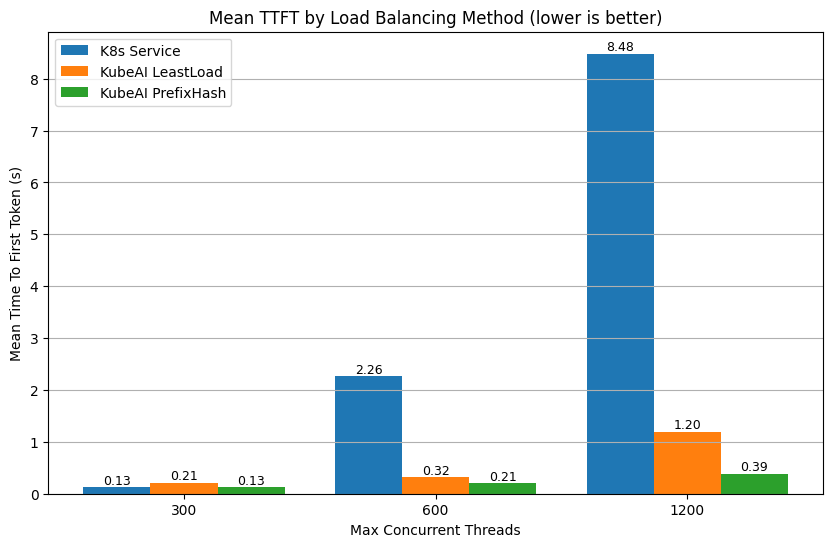

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def ttft_bar_plot(results):
    data_by_strategy = {}
    for res in results:
        bench = res['bench']
        max_threads = bench['max_concurrent_threads']
        ttft_str = res['result']['ttft']['mean']
        ttft_sec = parse_time(ttft_str)

        # Get the load balancing strategy; use "K8s - Service" if not defined.
        strategy = res.get('spec', {}).get('loadBalancing', {}).get('strategy', 'K8s Service')
        if strategy != "K8s Service":
            strategy = f"KubeAI {strategy}"

        if strategy not in data_by_strategy:
            data_by_strategy[strategy] = {"max_threads": [], "ttft": []}
        data_by_strategy[strategy]["max_threads"].append(max_threads)
        data_by_strategy[strategy]["ttft"].append(ttft_sec)

    # Convert the grouped data into a mapping for easier lookup:
    # strategy -> {max_concurrent_threads: ttft_sec}
    data_mapping = {}
    for strategy, data in data_by_strategy.items():
        data_mapping[strategy] = dict(zip(data["max_threads"], data["ttft"]))

    # Get the sorted unique max_concurrent_threads values across all groups.
    unique_x = sorted(set(
        max_thread 
        for data in data_by_strategy.values() 
        for max_thread in data["max_threads"]
    ))

    # Setup for a grouped bar chart.
    num_strategies = len(data_mapping)
    bar_width = 0.8 / num_strategies  # total width per group = 0.8
    x_indices = np.arange(len(unique_x))

    plt.figure(figsize=(10, 6))
    for i, (strategy, mapping) in enumerate(data_mapping.items()):
        # Retrieve ttft values for each unique max_concurrent_threads (default to 0 if not present)
        y_values = [mapping.get(x, 0) for x in unique_x]
        # Shift each strategy's bars for a grouped effect.
        bars = plt.bar(x_indices + i * bar_width, y_values, width=bar_width, label=strategy)
        # Annotate each bar with its height (i.e. TTFT value)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel("Max Concurrent Threads")
    plt.ylabel("Mean Time To First Token (s)")
    plt.title("Mean TTFT by Load Balancing Method (lower is better)")
    plt.xticks(x_indices + bar_width * (num_strategies - 1) / 2, unique_x)
    plt.legend()
    plt.grid(axis='y')
    plt.savefig("ttft_8r.png", dpi=300)
    plt.show()

# Seems a pod failure happened with 2400 concurrency so removing invalid results.
filtered_data = list(filter(lambda item: item.get("bench")['max_concurrent_threads'] != 2400, all_results))
filtered_data.reverse()
ttft_bar_plot(filtered_data)

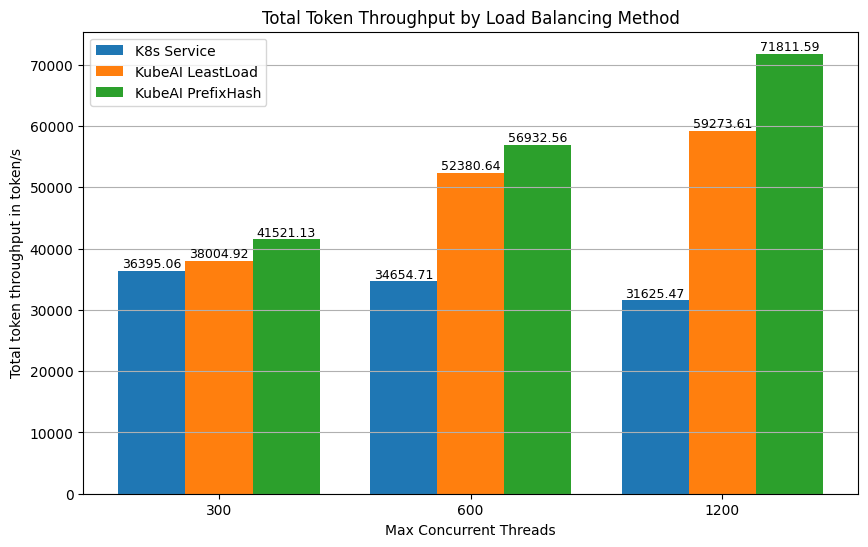

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def total_token_throughput_bar_plot(results):
    data_by_strategy = {}
    for res in results:
        bench = res['bench']
        max_threads = bench['max_concurrent_threads']
        throughput = res['result']['run_total_throughput']  # Using total token throughput
        
        # Get the load balancing strategy; use "K8s Service" if not defined.
        strategy = res.get('spec', {}).get('loadBalancing', {}).get('strategy', 'K8s Service')
        if strategy != "K8s Service":
            strategy = f"KubeAI {strategy}"

        if strategy not in data_by_strategy:
            data_by_strategy[strategy] = {"max_threads": [], "throughput": []}
        data_by_strategy[strategy]["max_threads"].append(max_threads)
        data_by_strategy[strategy]["throughput"].append(throughput)

    # Convert the grouped data into a mapping for easier lookup:
    # strategy -> {max_concurrent_threads: throughput}
    data_mapping = {}
    for strategy, data in data_by_strategy.items():
        data_mapping[strategy] = dict(zip(data["max_threads"], data["throughput"]))

    # Get the sorted unique max_concurrent_threads values across all groups.
    unique_x = sorted(set(
        max_thread 
        for data in data_by_strategy.values() 
        for max_thread in data["max_threads"]
    ))

    # Setup for a grouped bar chart.
    num_strategies = len(data_mapping)
    bar_width = 0.8 / num_strategies  # total width per group = 0.8
    x_indices = np.arange(len(unique_x))

    plt.figure(figsize=(10, 6))
    for i, (strategy, mapping) in enumerate(data_mapping.items()):
        # Retrieve throughput values for each unique max_concurrent_threads (default to 0 if not present)
        y_values = [mapping.get(x, 0) for x in unique_x]
        # Shift each strategy's bars for a grouped effect.
        bars = plt.bar(x_indices + i * bar_width, y_values, width=bar_width, label=strategy)
        # Annotate each bar with its height (i.e., the throughput value)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel("Max Concurrent Threads")
    plt.ylabel("Total token throughput in token/s")
    plt.title("Total Token Throughput by Load Balancing Method")
    plt.xticks(x_indices + bar_width * (num_strategies - 1) / 2, unique_x)
    plt.legend()
    plt.grid(axis='y')
    plt.savefig("throughput_8r.png", dpi=300)
    plt.show()

# Filter out any invalid results (for example, those with 2400 concurrency issues) and reverse the list.
filtered_data = list(filter(lambda item: item.get("bench")['max_concurrent_threads'] != 2400, all_results))
filtered_data.reverse()
total_token_throughput_bar_plot(filtered_data)

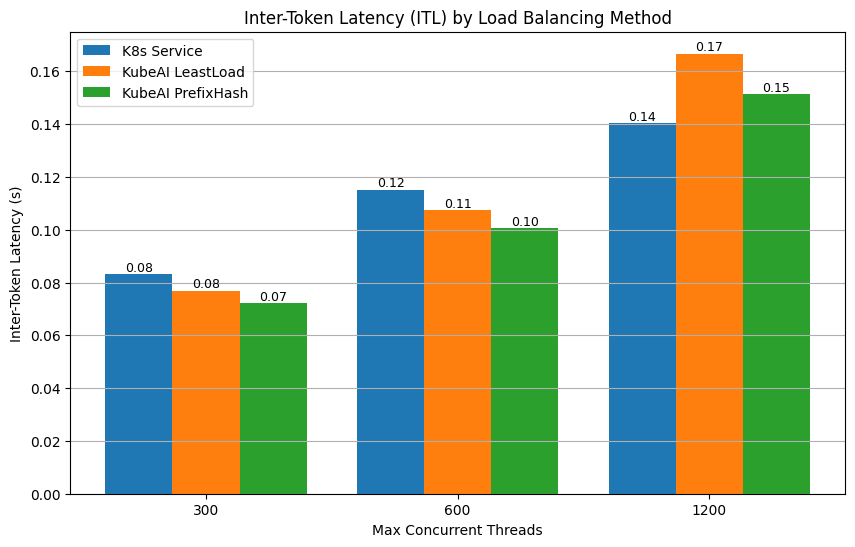

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def itl_bar_plot(results):
    data_by_strategy = {}
    for res in results:
        bench = res['bench']
        max_threads = bench['max_concurrent_threads']
        itl_str = res['result']['itl']['mean']
        itl_sec = parse_time(itl_str)

        # Get the load balancing strategy; use "K8s Service" if not defined.
        strategy = res.get('spec', {}).get('loadBalancing', {}).get('strategy', 'K8s Service')
        if strategy != "K8s Service":
            strategy = f"KubeAI {strategy}"

        if strategy not in data_by_strategy:
            data_by_strategy[strategy] = {"max_threads": [], "itl": []}
        data_by_strategy[strategy]["max_threads"].append(max_threads)
        data_by_strategy[strategy]["itl"].append(itl_sec)

    # Convert the grouped data into a mapping for easier lookup:
    # strategy -> {max_concurrent_threads: itl_sec}
    data_mapping = {}
    for strategy, data in data_by_strategy.items():
        data_mapping[strategy] = dict(zip(data["max_threads"], data["itl"]))

    # Get the sorted unique max_concurrent_threads values across all groups.
    unique_x = sorted(set(
        max_thread 
        for data in data_by_strategy.values() 
        for max_thread in data["max_threads"]
    ))

    # Setup for a grouped bar chart.
    num_strategies = len(data_mapping)
    bar_width = 0.8 / num_strategies  # total width per group = 0.8
    x_indices = np.arange(len(unique_x))

    plt.figure(figsize=(10, 6))
    for i, (strategy, mapping) in enumerate(data_mapping.items()):
        # Retrieve ITL values for each unique max_concurrent_threads (default to 0 if not present)
        y_values = [mapping.get(x, 0) for x in unique_x]
        # Shift each strategy's bars for a grouped effect.
        bars = plt.bar(x_indices + i * bar_width, y_values, width=bar_width, label=strategy)
        # Annotate each bar with its height (i.e., the ITL value)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel("Max Concurrent Threads")
    plt.ylabel("Inter-Token Latency (s)")
    plt.title("Inter-Token Latency (ITL) by Load Balancing Method")
    plt.xticks(x_indices + bar_width * (num_strategies - 1) / 2, unique_x)
    plt.legend()
    plt.grid(axis='y')
    plt.savefig("itl_8r.png", dpi=300)
    plt.show()

# Filter out any invalid results (for example, those with 2400 concurrency issues) and reverse the list.
filtered_data = list(filter(lambda item: item.get("bench")['max_concurrent_threads'] != 2400, all_results))
filtered_data.reverse()
itl_bar_plot(filtered_data)
